### Thermal Zone ODEs

The equations governing the thermal dynamics of the zones are given by the following system of ordinary differential equations (ODEs):

For the **internal temperature** \( T_{\text{int\_Zone(i)}} \):

$$
\frac{dT_{\text{int\_Zone(i)}}}{dt} = \frac{1}{C_{\text{res\_Zone(i)}}} \times \left[ \left( \frac{1}{R_{\text{i\_Zone(i)}}} + \frac{1}{R_{\text{o\_Zone(i)}}} + \sum_{j=1}^{n} \frac{1}{R_{\text{Zone(i)}}} \right) \times T_{\text{int\_Zone(i)}} + \frac{1}{R_{\text{f\_Zone(i)}}} \times T_{\text{ext}} + Q_{\text{res\_Zone(i)}} \right]
$$

For the **structural temperature** \( T_{\text{s\_Zone(i)}} \):

$$
\frac{dT_{\text{s\_Zone(i)}}}{dt} = \frac{1}{C_{\text{s\_Zone(i)}}} \times \left[ \frac{1}{R_{\text{i\_Zone(i)}}} \times T_{\text{int\_Zone(i)}} + \frac{1}{R_{\text{o\_Zone(i)}}} \times T_{\text{ext}} + Q_{\text{s\_Zone(i)}} \right]
$$

### Parameters:

- \( C_{\text{res\_Zone(i)}} \): Indoor heat capacity (J/K)
- \( C_{\text{s\_Zone(i)}} \): Wall structure heat capacity (J/K)
- \( R_{\text{i\_Zone(i)}} \): Internal resistance (K/W)
- \( R_{\text{o\_Zone(i)}} \): External resistance (K/W)
- \( R_{\text{f\_Zone(i)}} \): Window (air infiltration) resistance (K/W)
- \( T_{\text{ext}} \): External temperature (°C)
- \( Q_{\text{res\_Zone(i)}} \): Heating power input (W)
- \( Q_{\text{s\_Zone(i)}} \): Solar power input (W)


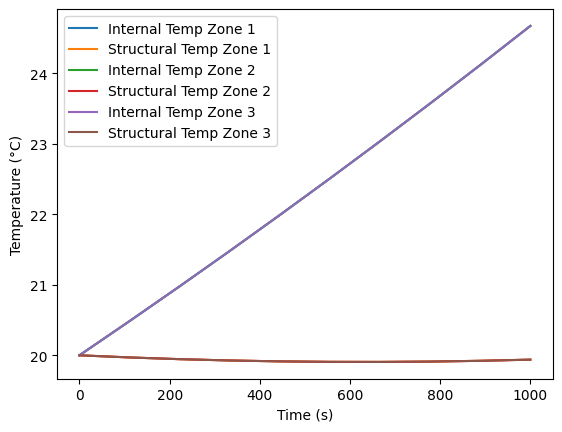

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the thermal model with zone interactions
def thermal_model(T, t, params):
    num_zones = len(T) // 2  # Number of zones (half the length of T since it includes T_int and T_s for each zone)
    dT_dt = np.zeros_like(T)  # Initialize the derivatives
    
    C_res, C_s, R_i, R_o, R_f, T_ext, Q_res, Q_s, R_zone = params
    
    for i in range(num_zones):
        T_int_i = T[2 * i]
        T_s_i = T[2 * i + 1]
        
        # Sum over other zones (j)
        sum_T_zone = 0
        for j in range(num_zones):
            if i != j:
                T_int_j = T[2 * j]
                sum_T_zone += (T_int_j - T_int_i) / R_zone[i, j]  # Heat exchange with zone j
        
        # ODE for internal temperature of zone i
        dT_int_dt = (1 / C_res[i]) * (
            (1 / R_i[i] + 1 / R_o[i]) * T_int_i + 1 / R_f[i] * T_ext[i] + Q_res[i] + sum_T_zone
        )
        
        # ODE for structural temperature of zone i
        dT_s_dt = (1 / C_s[i]) * (
            (1 / R_i[i]) * (T_int_i - T_s_i) + (1 / R_o[i]) * (T_ext[i] - T_s_i) + Q_s[i]
        )
        
        dT_dt[2 * i] = dT_int_dt
        dT_dt[2 * i + 1] = dT_s_dt
    
    return dT_dt

# Number of zones
num_zones = 3

# Time points
t = np.linspace(0, 1000, 10)

# Initial conditions: [T_int_Zone1, T_s_Zone1, T_int_Zone2, T_s_Zone2, ..., T_int_ZoneN, T_s_ZoneN]
T0 = [20, 20] * num_zones  # Initial temperatures (20°C for internal and structural for each zone)

# Parameters for each zone: lists with length equal to num_zones
C_res = [1e6] * num_zones  # Capacitance of the air in each zone
C_s = [1e6] * num_zones  # Capacitance of the structure in each zone
R_i = [0.01] * num_zones  # Internal thermal resistance for each zone
R_o = [0.02] * num_zones  # External thermal resistance for each zone
R_f = [0.03] * num_zones  # Air infiltration resistance for each zone
T_ext = [10] * num_zones  # External temperature for each zone
Q_res = [1000] * num_zones  # Heating power input for each zone
Q_s = [200] * num_zones  # Solar flux input for each zone

# Resistance between zones: R_zone[i,j] is the thermal resistance between zone i and zone j
R_zone = np.ones((num_zones, num_zones)) * 0.05
np.fill_diagonal(R_zone, np.inf)  # Set the diagonal to infinity (no self-interaction)

# Combine parameters
params = (C_res, C_s, R_i, R_o, R_f, T_ext, Q_res, Q_s, R_zone)

# Solve the ODEs
sol = odeint(thermal_model, T0, t, args=(params,))  

# Plot the results
for i in range(num_zones):
    plt.plot(t, sol[:, 2 * i], label=f'Internal Temp Zone {i+1}')
    plt.plot(t, sol[:, 2 * i + 1], label=f'Structural Temp Zone {i+1}')

plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()
